In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install --upgrade grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=ae31d3bb4236787e6165a6afac344cb44f3f56a2ec260e9151407acd6d2981ad
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [1]:
# Imports and device setup
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

scripts_dir = os.path.abspath('/content/drive/My Drive/chest_xray_classification/scripts')
if scripts_dir not in sys.path:
    sys.path.insert(0, scripts_dir)

utils_dir = os.path.abspath('/content/drive/My Drive/chest_xray_classification/utils')
if utils_dir not in sys.path:
    sys.path.insert(0, utils_dir)

from data_utils import ChestXrayDataset, train_transform, test_transform, filter_by_image_range
from model import create_model
from train import train_model
from eval import evaluate_model
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [2]:
labels_df = pd.read_csv('/content/drive/MyDrive/chest_xray_classification/data/labels.csv')

all_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
              'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
              'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'No Finding']

for label in all_labels:
    labels_df[label] = labels_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

labels_df['Labels'] = labels_df[all_labels].values.tolist()

train_start_img = '00001336_000.png'
train_end_img = '00003923_013.png'
additional_train_start_img = '00006585_007.png'
additional_train_end_img = '00009232_003.png'

val_start_img = '00000001_000.png'
val_end_img = '00001335_006.png'

test_start_img = '00003923_014.png'
test_end_img = '00006585_006.png'

original_train_df = filter_by_image_range(labels_df, train_start_img, train_end_img)
additional_train_df = filter_by_image_range(labels_df, additional_train_start_img, additional_train_end_img)
train_df = pd.concat([original_train_df, additional_train_df], ignore_index=True)
val_df = filter_by_image_range(labels_df, val_start_img, val_end_img)
test_df = filter_by_image_range(labels_df, test_start_img, test_end_img)

train_img_dir = '/content/drive/My Drive/chest_xray_classification/data/images/train/images'
val_img_dir = '/content/drive/My Drive/chest_xray_classification/data/images/val/images'
test_img_dir = '/content/drive/My Drive/chest_xray_classification/data/images/test/images'

train_dataset = ChestXrayDataset(train_df, train_img_dir, transform=train_transform)
val_dataset = ChestXrayDataset(val_df, val_img_dir, transform=test_transform)
test_dataset = ChestXrayDataset(test_df, test_img_dir, transform=test_transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [22]:
# Initialize, train, and save model
model = create_model()
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

model_save_path = '/content/drive/My Drive/chest_xray_classification/models/saved_model.pth'
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 0.1925, Validation Loss: 0.2101
Epoch [2/10], Training Loss: 0.1843, Validation Loss: 0.1980
Epoch [3/10], Training Loss: 0.1817, Validation Loss: 0.1956
Epoch [4/10], Training Loss: 0.1790, Validation Loss: 0.1949
Epoch [5/10], Training Loss: 0.1763, Validation Loss: 0.1950
Epoch [6/10], Training Loss: 0.1755, Validation Loss: 0.1912
Epoch [7/10], Training Loss: 0.1740, Validation Loss: 0.1941
Epoch [8/10], Training Loss: 0.1725, Validation Loss: 0.1932
Epoch [9/10], Training Loss: 0.1706, Validation Loss: 0.1877
Epoch [10/10], Training Loss: 0.1695, Validation Loss: 0.1873
Model saved to /content/drive/My Drive/chest_xray_classification/models/saved_model.pth


In [3]:
# Load saved model
model_load_path = '/content/drive/My Drive/chest_xray_classification/models/saved_model.pth'
loaded_model = create_model()
loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model = loaded_model.to(device)

print("Model loaded successfully.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 172MB/s]
<ipython-input-3-478eaefe7e31>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. 

Model loaded successfully.


In [4]:
# Evaluate the loaded model
evaluation_results = evaluate_model(loaded_model, test_loader, device, all_labels)

import json

results_save_path = '/content/drive/My Drive/chest_xray_classification/models/evaluation_results.json'
with open(results_save_path, 'w') as f:
    json.dump(evaluation_results, f)

print(f"Evaluation results saved to {results_save_path}")


Atelectasis: AUC-ROC = 0.7629
Cardiomegaly: AUC-ROC = 0.8666
Consolidation: AUC-ROC = 0.7639
Edema: AUC-ROC = 0.8377
Effusion: AUC-ROC = 0.8434
Emphysema: AUC-ROC = 0.8083
Fibrosis: AUC-ROC = 0.7554
Hernia: AUC-ROC = 0.7021
Infiltration: AUC-ROC = 0.7489
Mass: AUC-ROC = 0.7706
Nodule: AUC-ROC = 0.6987
Pleural_Thickening: AUC-ROC = 0.7770
Pneumonia: AUC-ROC = 0.6899
Pneumothorax: AUC-ROC = 0.7465
No Finding: AUC-ROC = 0.7570
Overall Accuracy: 0.9384
Evaluation results saved to /content/drive/My Drive/chest_xray_classification/models/evaluation_results.json


In [5]:
# Load evaluation results
with open(results_save_path, 'r') as f:
    loaded_results = json.load(f)

print("Loaded Evaluation Results:")
print(json.dumps(loaded_results, indent=4))

Loaded Evaluation Results:
{
    "auc_scores": {
        "Atelectasis": 0.7629225124497223,
        "Cardiomegaly": 0.8665977542125755,
        "Consolidation": 0.7639474401197994,
        "Edema": 0.8377084424372641,
        "Effusion": 0.8434197150334399,
        "Emphysema": 0.808315691726751,
        "Fibrosis": 0.7554460196292258,
        "Hernia": 0.7021127465705417,
        "Infiltration": 0.7489118279230675,
        "Mass": 0.7706379552006508,
        "Nodule": 0.6987081205080147,
        "Pleural_Thickening": 0.7769777941464998,
        "Pneumonia": 0.6898717819165475,
        "Pneumothorax": 0.7465246743089351,
        "No Finding": 0.7569820629929663
    },
    "accuracy": 0.9383866666666667
}


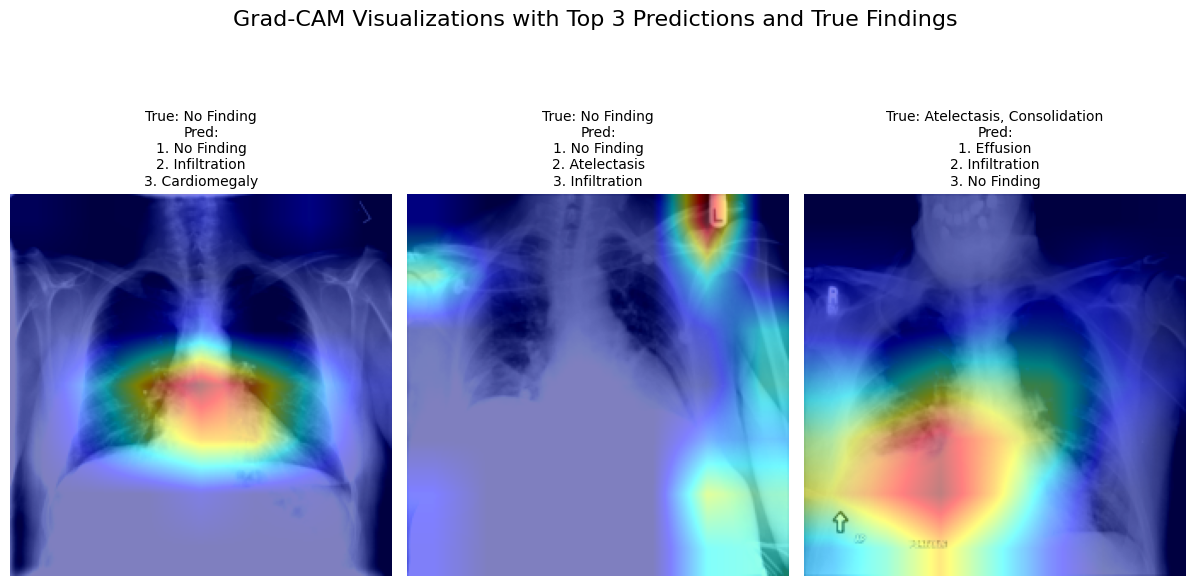

In [52]:
# Display Grad-CAM for set of random images with top 3 predictions
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import random

def denormalize_image(image):
    image = image.cpu().numpy().transpose(1, 2, 0)
    image = image * np.array([0.5]) + np.array([0.5])
    return np.clip(image, 0, 1)

num_samples = 3
indices = random.sample(range(len(test_dataset)), num_samples)

target_layers = [loaded_model.features.denseblock4]

plt.figure(figsize=(20, 15))

for i, idx in enumerate(indices):
    image, labels = test_dataset[idx]
    image = image.to(device)
    true_labels = np.array(labels)
    true_findings = [all_labels[j] for j, label in enumerate(true_labels) if label == 1]

    loaded_model.eval()
    with torch.no_grad():
        outputs = loaded_model(image.unsqueeze(0))
        probs = torch.sigmoid(outputs).cpu().numpy()[0]

    top_indices = probs.argsort()[-3:][::-1]
    top_labels = [all_labels[j] for j in top_indices]
    cam = GradCAM(model=loaded_model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=image.unsqueeze(0), targets=[ClassifierOutputTarget(top_indices[0])])
    grayscale_cam = grayscale_cam[0, :]
    original_img = denormalize_image(image)
    visualization = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
    plt.subplot(2, 5, i + 1)
    plt.imshow(visualization)
    plt.axis('off')
    pred_text = "\n".join([f"{rank}. {label}" for rank, label in enumerate(top_labels, start=1)])
    true_text = f"True: {', '.join(true_findings)}" if true_findings else "True: None"
    combined_text = f"{true_text}\nPred:\n{pred_text}"
    plt.title(combined_text, fontsize=10)

plt.suptitle("Grad-CAM Visualizations with Top 3 Predictions and True Findings", fontsize=16, x=0.3)
plt.tight_layout()
plt.show()
